In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from einops import rearrange

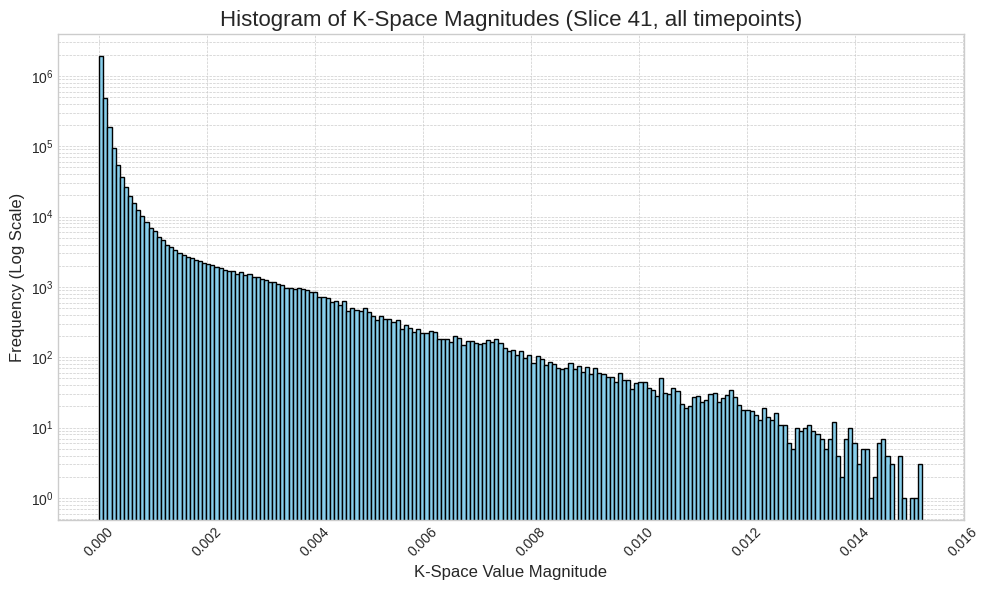

In [5]:


kspace_path = '/ess/scratch/scratch1/rachelgordon/dce-8tf/binned_kspace/fastMRI_breast_001_2.h5'

with h5py.File(kspace_path, 'r') as f:

    kspace = torch.tensor(f['ktspace'][:])

    kspace_slice = kspace[41]

    # 1. Calculate the magnitude of the complex values.
    kspace_magnitudes = np.abs(kspace_slice)

    # 2. Flatten the 4D array into a 1D list of all values.
    all_values = kspace_magnitudes.flatten()

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the histogram with a logarithmic y-axis to see the full distribution
    ax.hist(all_values, bins=200, color='skyblue', edgecolor='black', log=True)

    ax.set_title('Histogram of K-Space Magnitudes (Slice 41, all timepoints)', fontsize=16)
    ax.set_xlabel('K-Space Value Magnitude', fontsize=12)
    ax.set_ylabel('Frequency (Log Scale)', fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Improve readability for potentially very small or large numbers
    ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

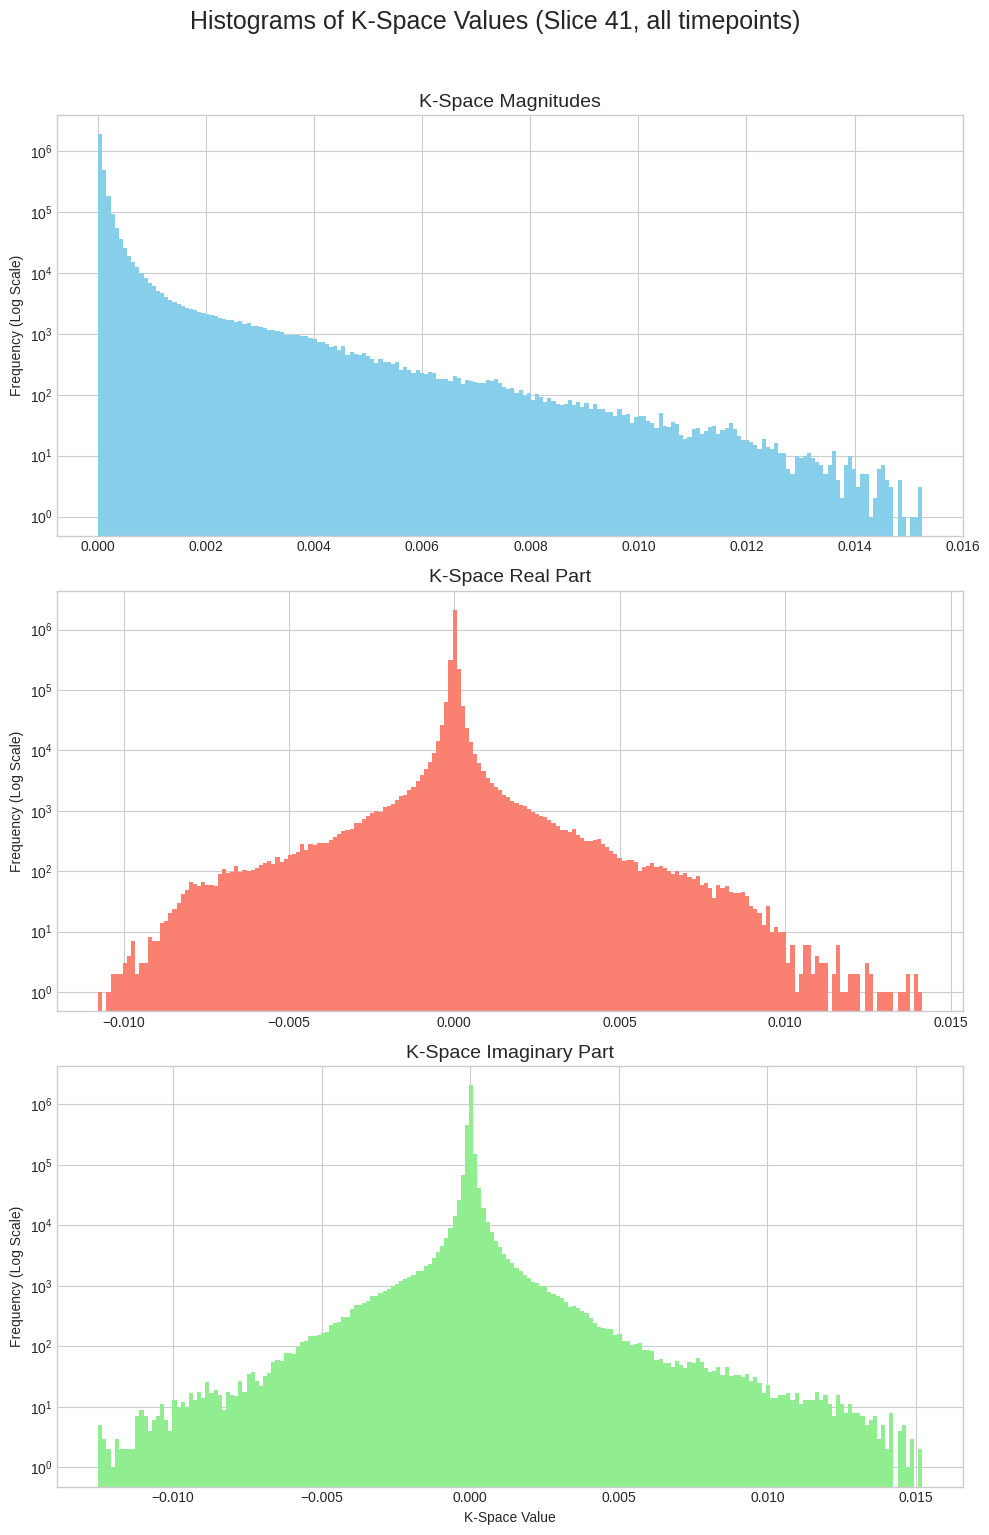

In [16]:
with h5py.File(kspace_path, 'r') as f:
    kspace = torch.tensor(f['ktspace'][:])

    kspace_slice = kspace[41]


    # --- Prepare Data for Histograms ---
    magnitudes = np.abs(kspace_slice).flatten()
    real_parts = kspace_slice.real.flatten()
    imag_parts = kspace_slice.imag.flatten()

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=False) # Not sharing x-axis

    # Plot Magnitude
    axes[0].hist(magnitudes, bins=200, color='skyblue', log=True)
    axes[0].set_title('K-Space Magnitudes', fontsize=14)
    axes[0].set_ylabel('Frequency (Log Scale)')

    # Plot Real Part
    axes[1].hist(real_parts, bins=200, color='salmon', log=True)
    axes[1].set_title('K-Space Real Part', fontsize=14)
    axes[1].set_ylabel('Frequency (Log Scale)')
    
    # Plot Imaginary Part
    axes[2].hist(imag_parts, bins=200, color='lightgreen', log=True)
    axes[2].set_title('K-Space Imaginary Part', fontsize=14)
    axes[2].set_ylabel('Frequency (Log Scale)')
    axes[2].set_xlabel('K-Space Value')

    fig.suptitle('Histograms of K-Space Values (Slice 41, all timepoints)', fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()

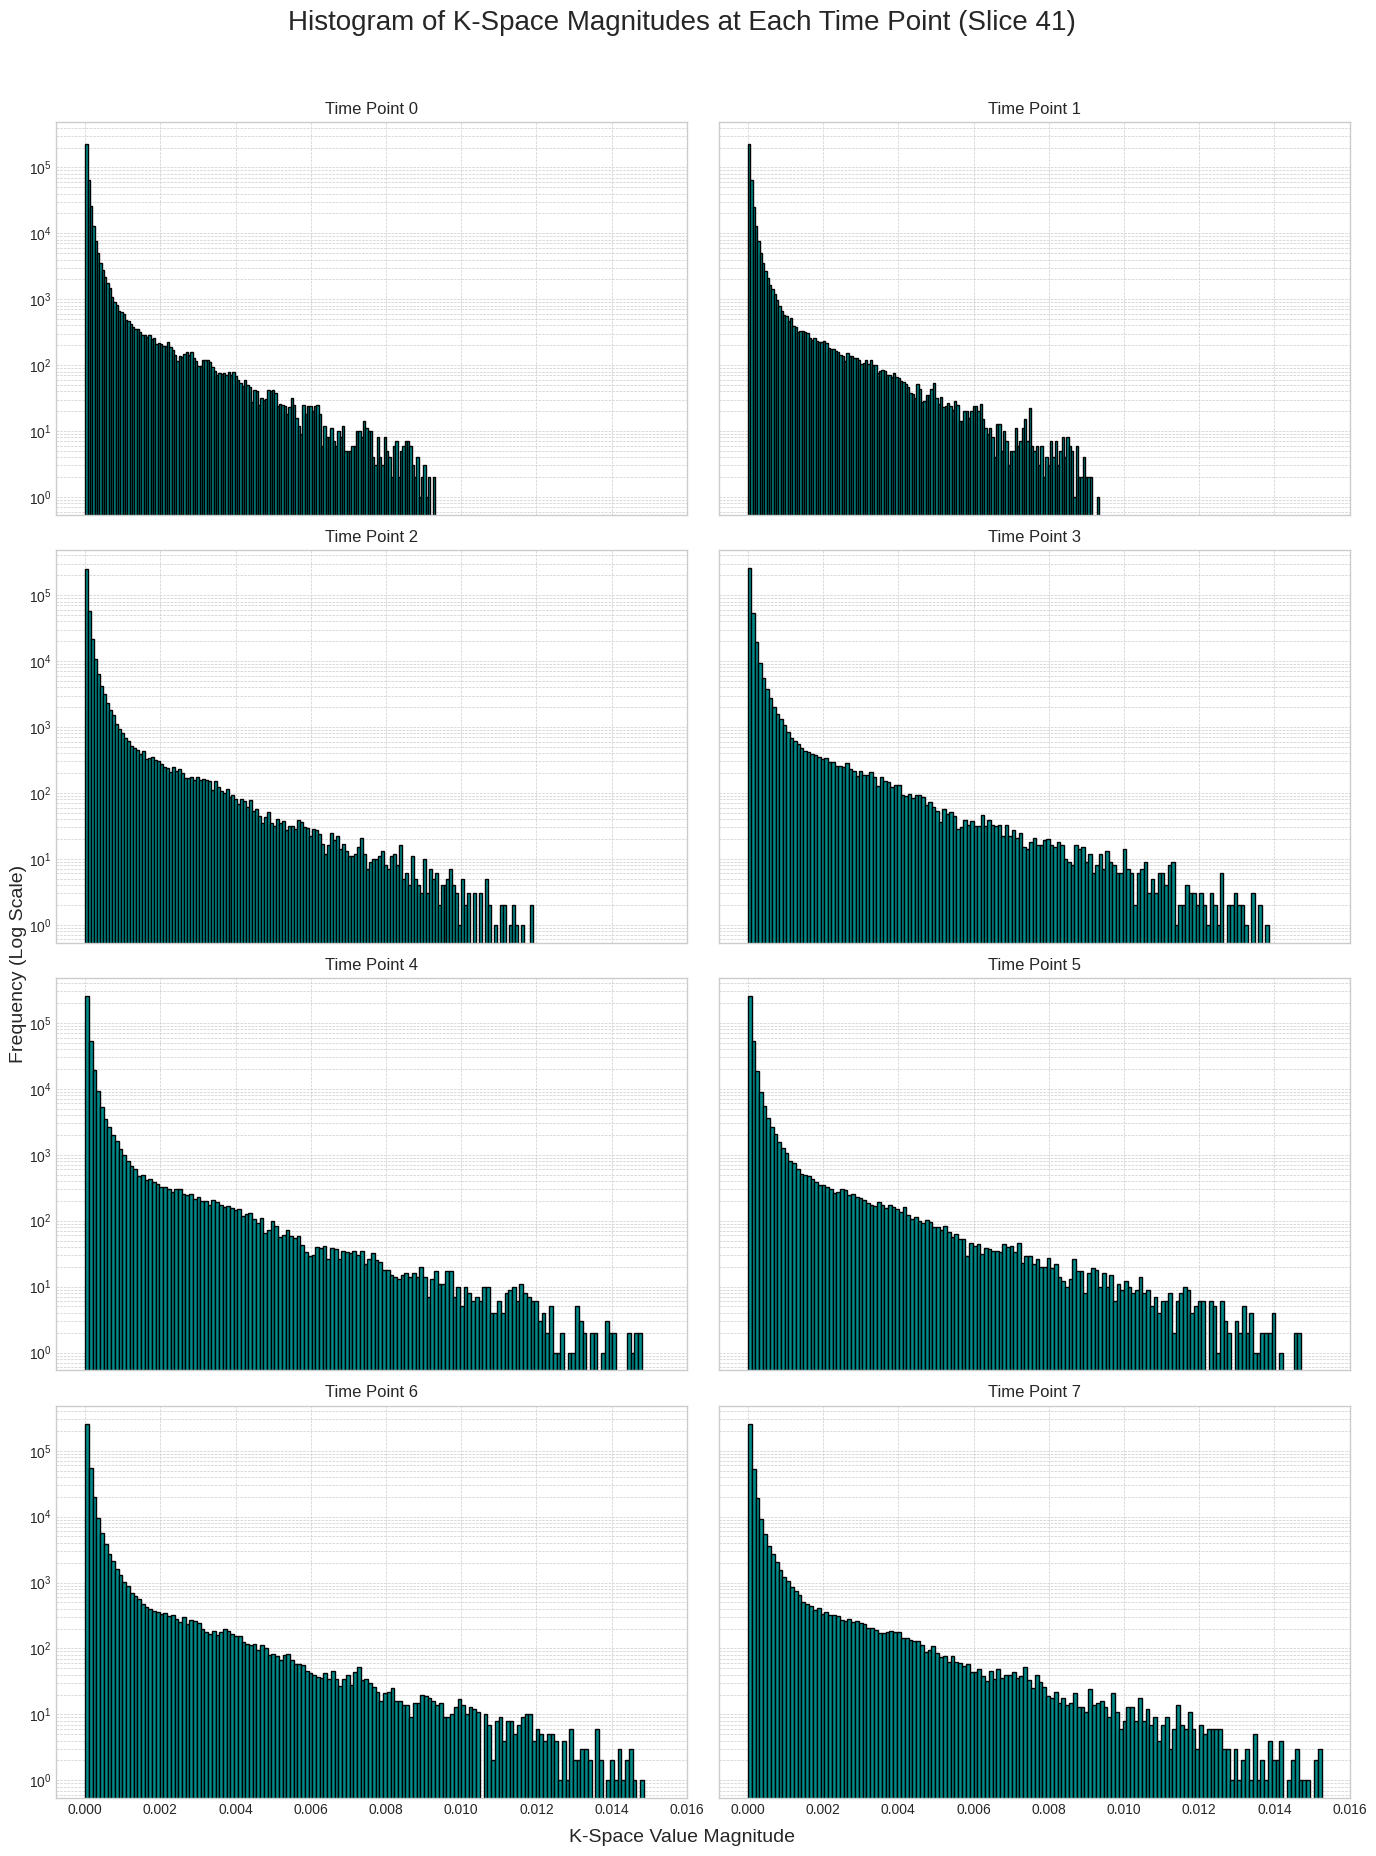

In [17]:
with h5py.File(kspace_path, 'r') as f:
    kspace = torch.tensor(f['ktspace'][:])

    kspace_slice = kspace[41]

    
    num_timepoints = kspace_slice.shape[0]

    # --- Plotting Setup ---
    # Create a 4x2 grid of subplots.
    # sharex and sharey make it easier to compare histograms.
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 18), sharex=True, sharey=True)
    
    # Flatten the 2D array of axes into a 1D array for easy iteration
    axes = axes.flatten()

    # --- Loop Through Each Time Point and Plot ---
    for t in range(num_timepoints):
        # Get the current axis from our flattened array
        ax = axes[t]
        
        # 1. Slice the data to get only the current time point
        kspace_at_time_t = kspace_slice[t, :, :, :]
        
        # 2. Calculate the magnitude of the complex values
        magnitudes = np.abs(kspace_at_time_t)
        
        # 3. Flatten the array into a 1D list for the histogram
        all_values_at_t = magnitudes.flatten()
        
        # 4. Plot the histogram for this time point
        ax.hist(all_values_at_t, bins=150, color='darkcyan', edgecolor='black', log=True)
        
        ax.set_title(f'Time Point {t}', fontsize=12)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # --- Final Touches for the Whole Figure ---
    # Add a main title for the entire figure
    fig.suptitle('Histogram of K-Space Magnitudes at Each Time Point (Slice 41)', fontsize=20, y=1.03)

    # Add shared labels to the figure to avoid repetition
    fig.supxlabel('K-Space Value Magnitude', fontsize=14)
    fig.supylabel('Frequency (Log Scale)', fontsize=14)

    # Clean up layout to prevent titles/labels from overlapping
    plt.tight_layout(rect=[0, 0, 1, 1.01]) # Adjust rect to make space for suptitle
    
    # If there are more axes than timepoints (e.g., 8 plots for 7 timepoints), hide the unused ones
    for i in range(num_timepoints, len(axes)):
        axes[i].set_visible(False)
        
    plt.show()

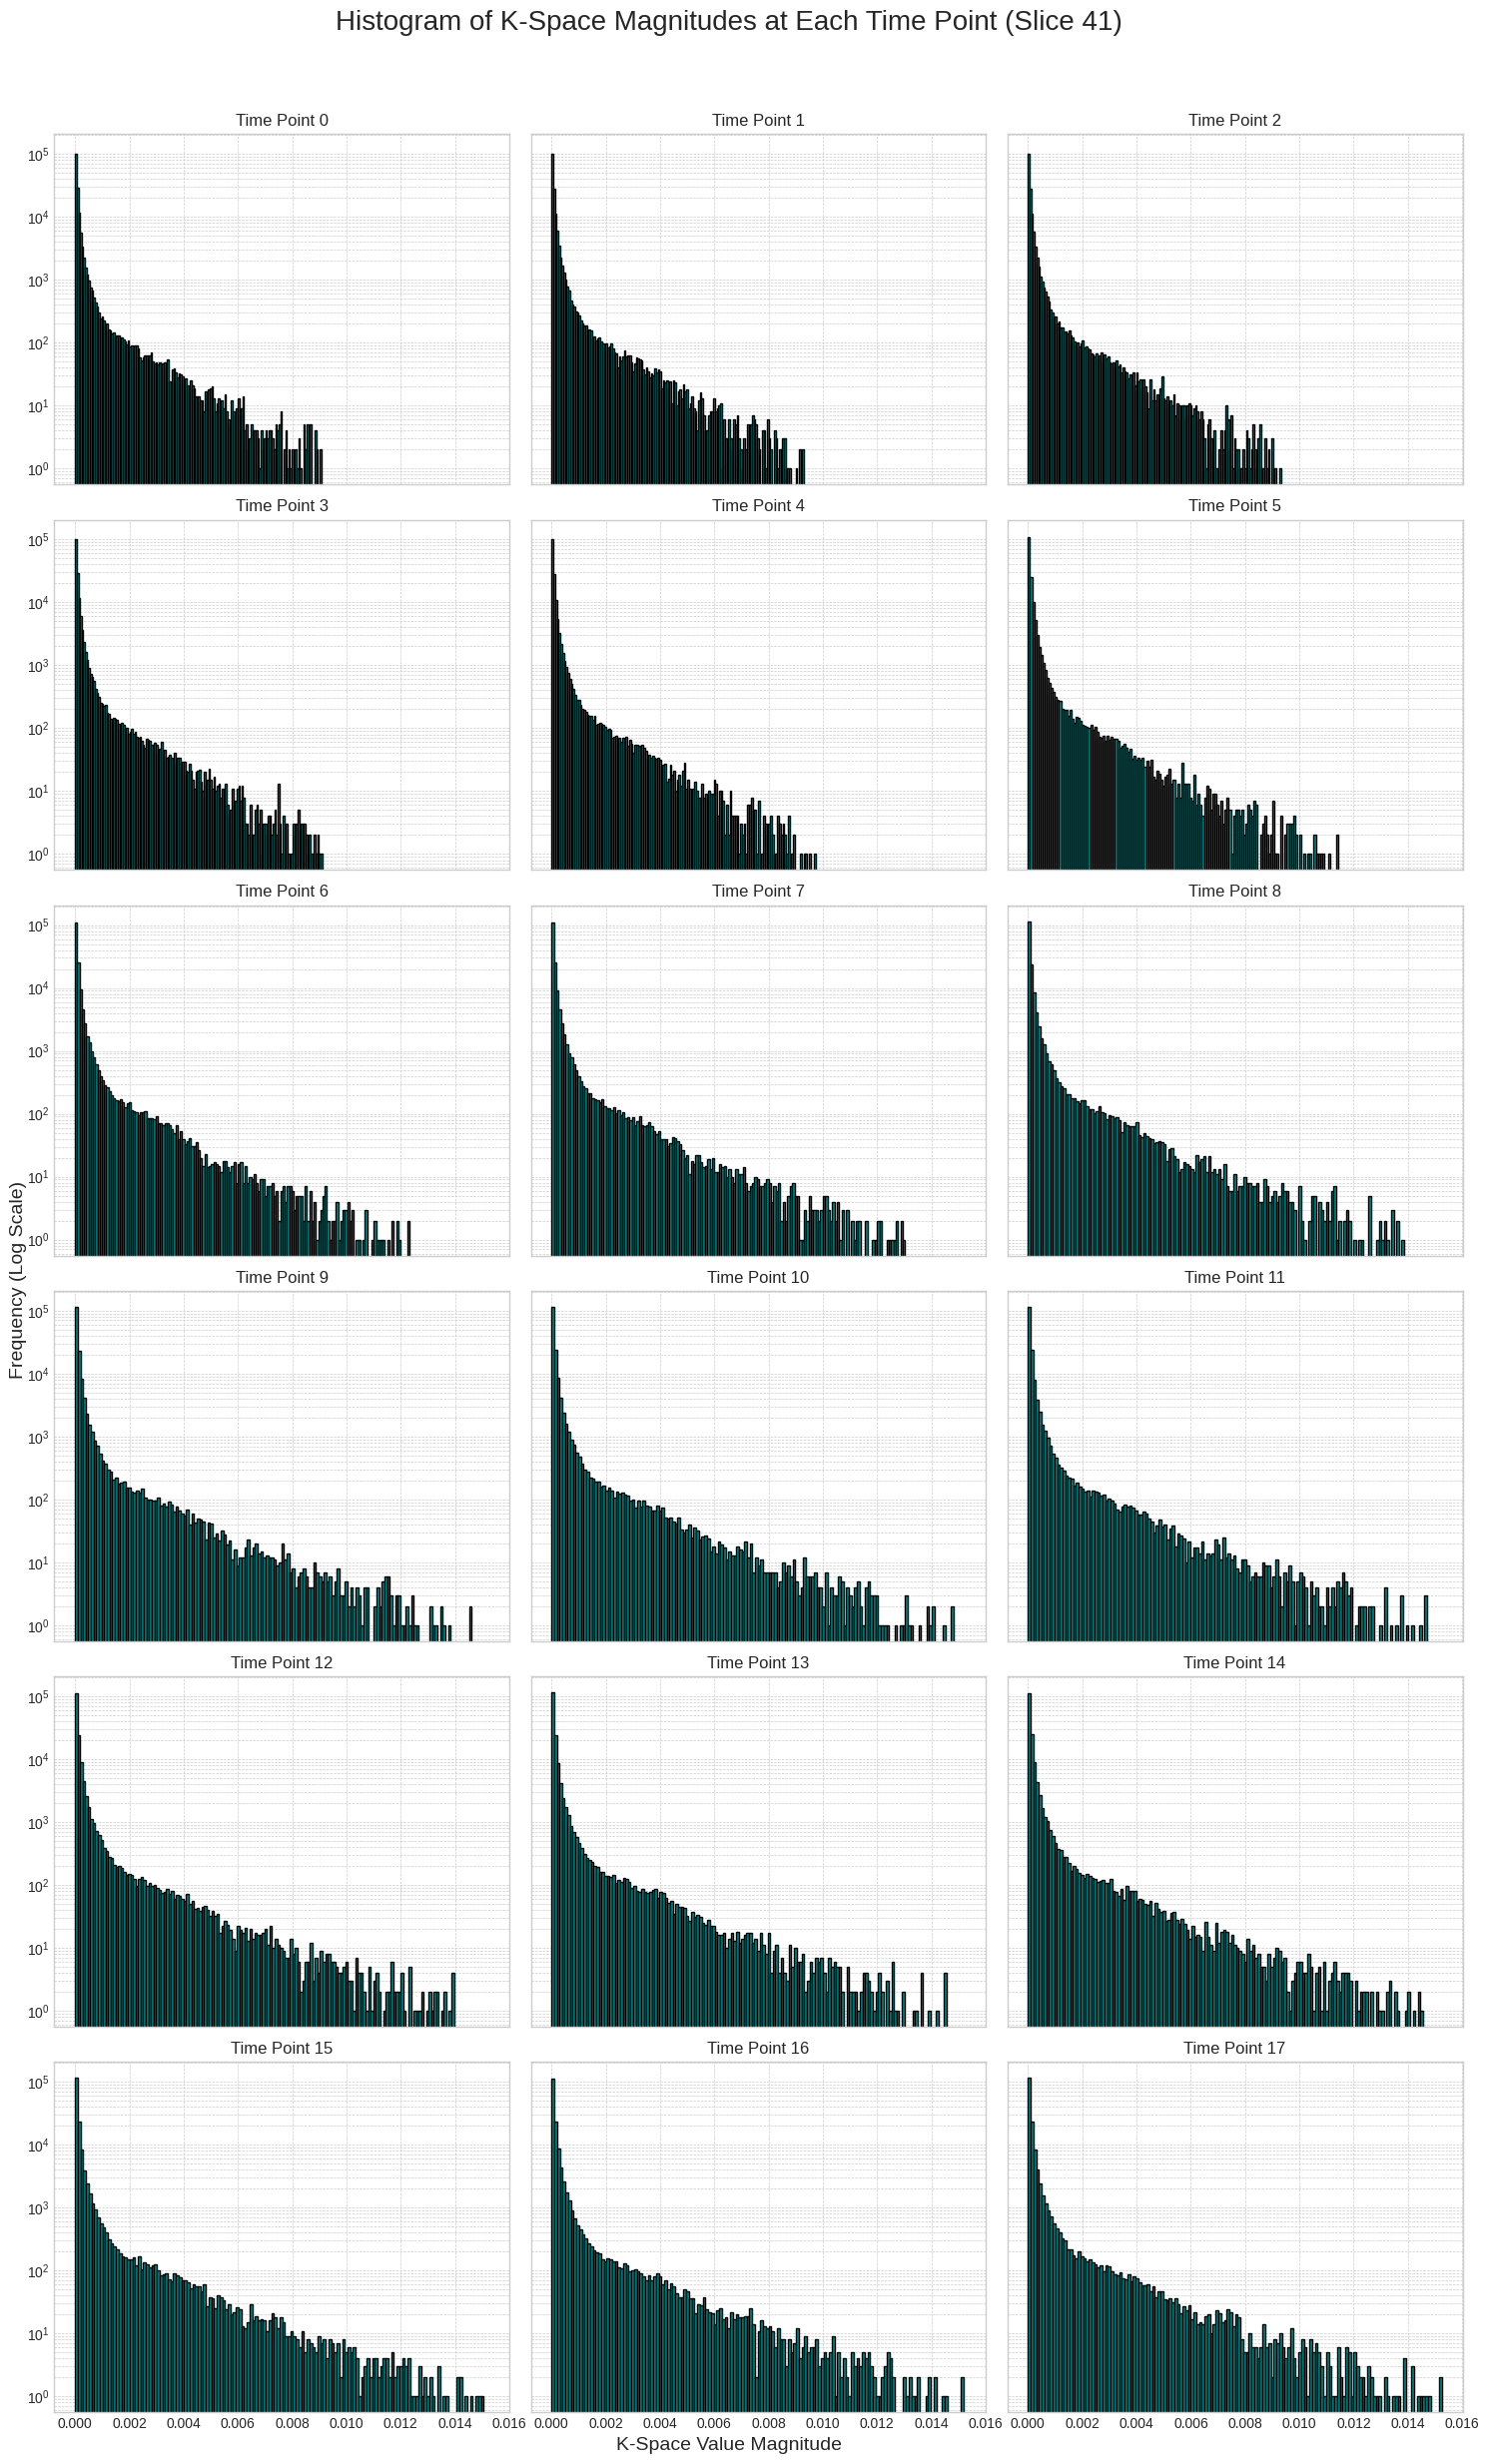

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import math

with h5py.File(kspace_path, 'r') as f:
    kspace = torch.tensor(f['ktspace'][:])

    kspace_slice = kspace[41]

N_coils = 16
spokes_per_frame = 16


total_spokes = kspace_slice.shape[0] * kspace_slice.shape[2]
N_samples = kspace_slice.shape[-1]
kspace = rearrange(kspace_slice, 't c sp sam -> t sp c sam')
kspace_flat = kspace.contiguous().view(total_spokes, N_coils, N_samples)


N_time = total_spokes // spokes_per_frame
kspace_binned = kspace_flat.view(N_time, spokes_per_frame, N_coils, N_samples)
kspace_slice = rearrange(kspace_binned, 't sp c sam -> t c sp sam')


num_timepoints = kspace_slice.shape[0]

# --- Dynamic Plotting Setup ---
# Determine the number of rows and columns for the subplot grid
# Aim for a layout that's roughly square or slightly wider.
# You can adjust these heuristics based on your typical range of timepoints.
if num_timepoints <= 2:
    nrows = 1
    ncols = num_timepoints
elif num_timepoints <= 4:
    nrows = 2
    ncols = math.ceil(num_timepoints / 2)
elif num_timepoints <= 6:
    nrows = 2
    ncols = 3
else: # For more timepoints, you might want 3 or more rows
    nrows = math.ceil(num_timepoints / 3) # Example: 3 columns per row
    ncols = 3

# Alternatively, a more generic approach:
# ncols = 3 # You can set a fixed number of columns if you prefer
# nrows = math.ceil(num_timepoints / ncols)


# Create the grid of subplots dynamically.
# sharex and sharey make it easier to compare histograms.
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows), sharex=True, sharey=True)

# Flatten the 2D array of axes into a 1D array for easy iteration
# This handles cases where nrows or ncols is 1, ensuring 'axes' is always iterable.
if num_timepoints == 1:
    axes = [axes] # Make it a list if there's only one subplot
else:
    axes = axes.flatten()

# --- Loop Through Each Time Point and Plot ---
for t in range(num_timepoints):
    # Get the current axis from our flattened array
    ax = axes[t]

    # 1. Slice the data to get only the current time point
    kspace_at_time_t = kspace_slice[t, :, :, :]

    # 2. Calculate the magnitude of the complex values
    magnitudes = np.abs(kspace_at_time_t)

    # 3. Flatten the array into a 1D list for the histogram
    all_values_at_t = magnitudes.flatten()

    # 4. Plot the histogram for this time point
    ax.hist(all_values_at_t, bins=150, color='darkcyan', edgecolor='black', log=True)

    ax.set_title(f'Time Point {t}', fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# --- Final Touches for the Whole Figure ---
# Add a main title for the entire figure
fig.suptitle('Histogram of K-Space Magnitudes at Each Time Point (Slice 41)', fontsize=20, y=1.03)

# Add shared labels to the figure to avoid repetition
fig.supxlabel('K-Space Value Magnitude', fontsize=14)
fig.supylabel('Frequency (Log Scale)', fontsize=14)

# Clean up layout to prevent titles/labels from overlapping
plt.tight_layout(rect=[0, 0, 1, 1.01]) # Adjust rect to make space for suptitle

# If there are more axes than timepoints, hide the unused ones
# len(axes) will be nrows * ncols.
for i in range(num_timepoints, len(axes)):
    axes[i].set_visible(False)

plt.show()

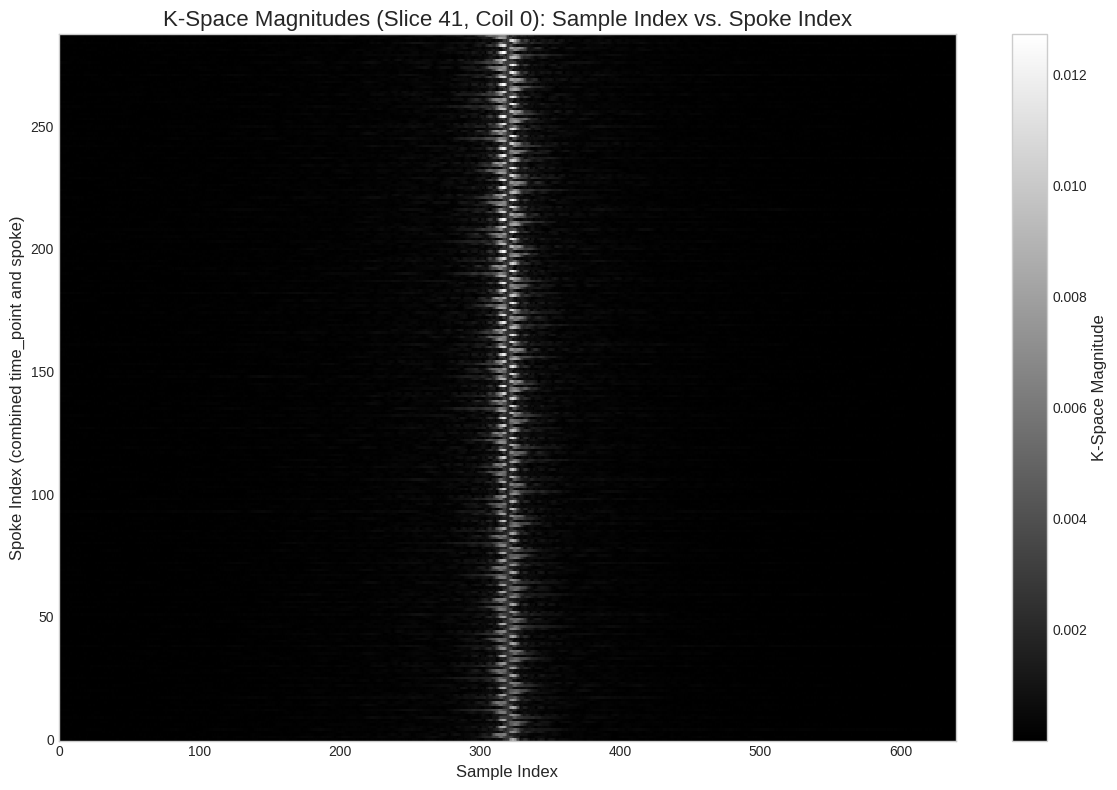

In [ ]:


kspace_path = '/ess/scratch/scratch1/rachelgordon/dce-8tf/binned_kspace/fastMRI_breast_001_2.h5'

with h5py.File(kspace_path, 'r') as f:
    kspace = torch.tensor(f['ktspace'][:])

    # Select a single slice and a single coil
    kspace_slice = kspace[41] # Your previously selected slice
    single_coil_kspace = kspace_slice[:, 0] # Select the first coil (index 0)

    # 1. Calculate the magnitude of the complex values for the selected coil.
    kspace_magnitudes = np.abs(single_coil_kspace.numpy())

    # The shape of single_coil_kspace is (time_points, spokes, samples)
    # We want to plot (samples, spokes) with magnitudes as color

    # Get dimensions
    time_points, spokes, samples = kspace_magnitudes.shape

    # For this plot, we'll consider all time points as independent "spoke" instances
    # and reshape the data to (spokes_total, samples)
    # where spokes_total = time_points * spokes
    
    # Reshape for plotting: (spokes_total, samples)
    # Each row will be a spoke, each column a sample
    # The 'spoke index' on the y-axis will effectively be (time_point * original_spokes_per_timepoint + spoke_in_timepoint)
    
    # Create an array to hold the reshaped magnitudes
    reshaped_magnitudes = kspace_magnitudes.reshape(time_points * spokes, samples)

    # Create meshgrid for plotting
    sample_indices = np.arange(samples)
    spoke_indices = np.arange(time_points * spokes) # This now represents the combined spoke index

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))

    # Use pcolormesh for a 2D color plot
    # X: sample_indices (horizontal axis)
    # Y: spoke_indices (vertical axis)
    # C: reshaped_magnitudes (color)
    mesh = ax.pcolormesh(sample_indices, spoke_indices, reshaped_magnitudes, cmap='gray', shading='auto')

    ax.set_title(f'K-Space Magnitudes (Slice 41, Coil 0): Sample Index vs. Spoke Index', fontsize=16)
    ax.set_xlabel('Sample Index', fontsize=12)
    ax.set_ylabel('Spoke Index (combined time_point and spoke)', fontsize=12)
    
    # Add a color bar
    cbar = fig.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05)
    cbar.set_label('K-Space Magnitude', fontsize=12)

    plt.tight_layout()
    plt.show()

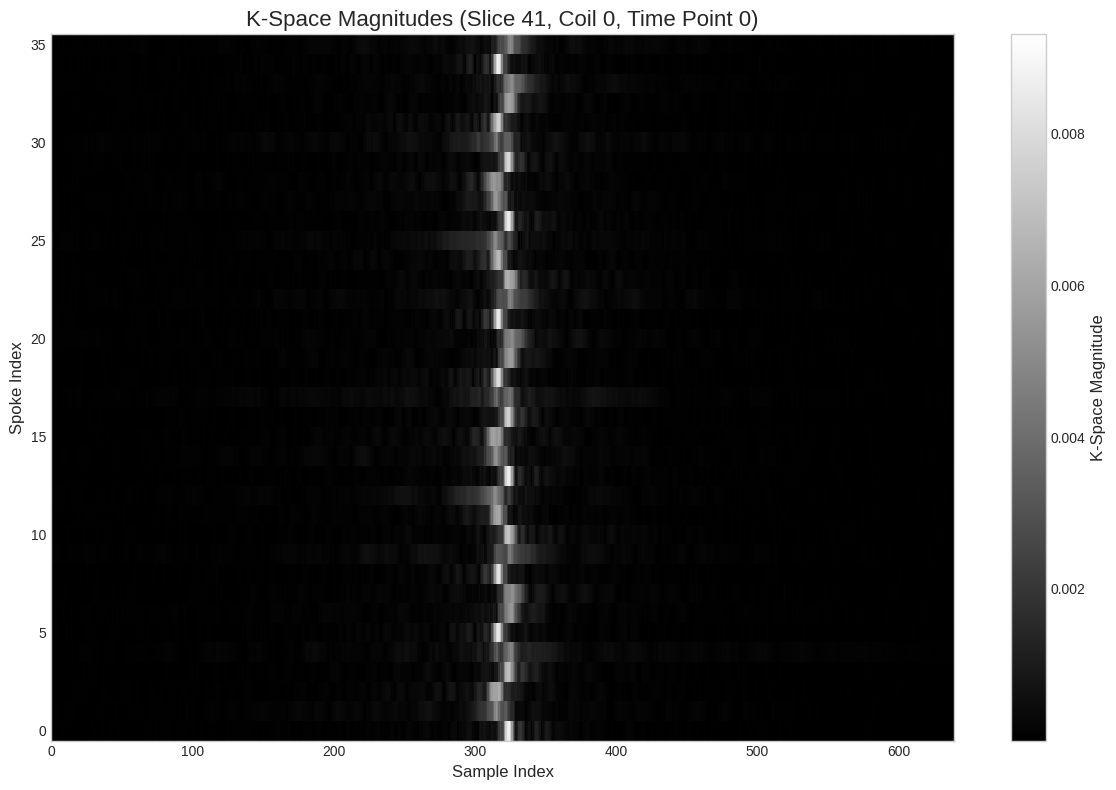

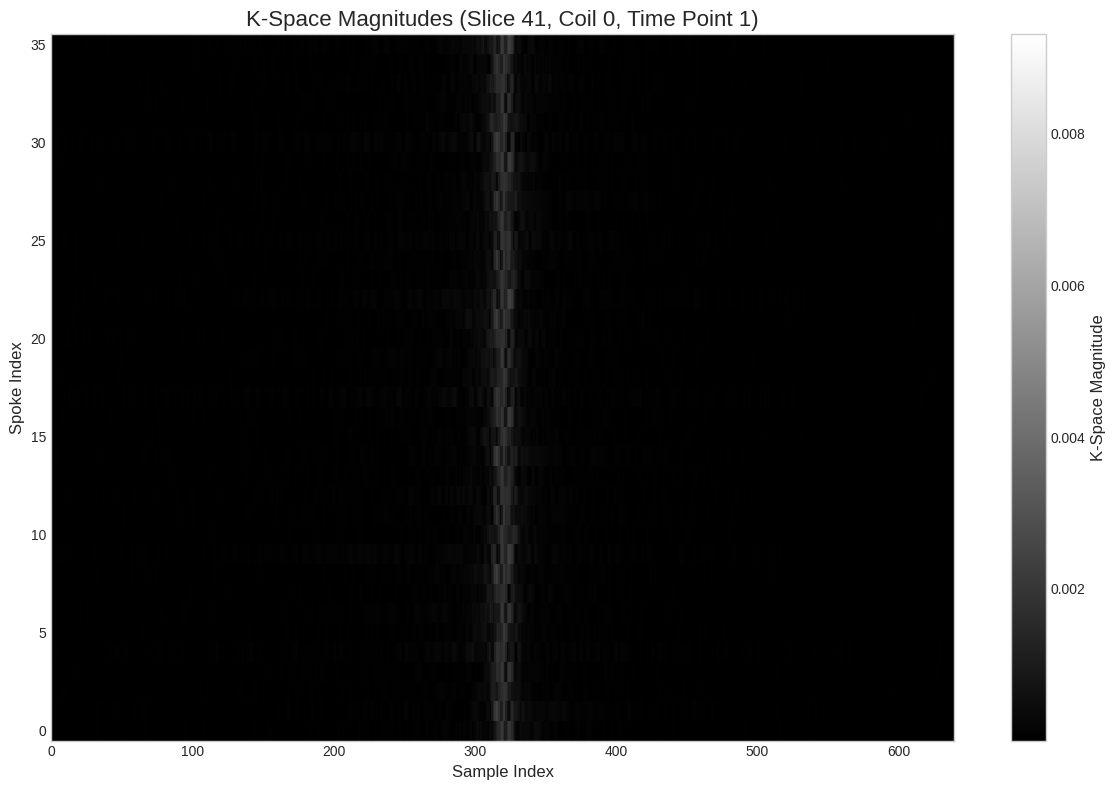

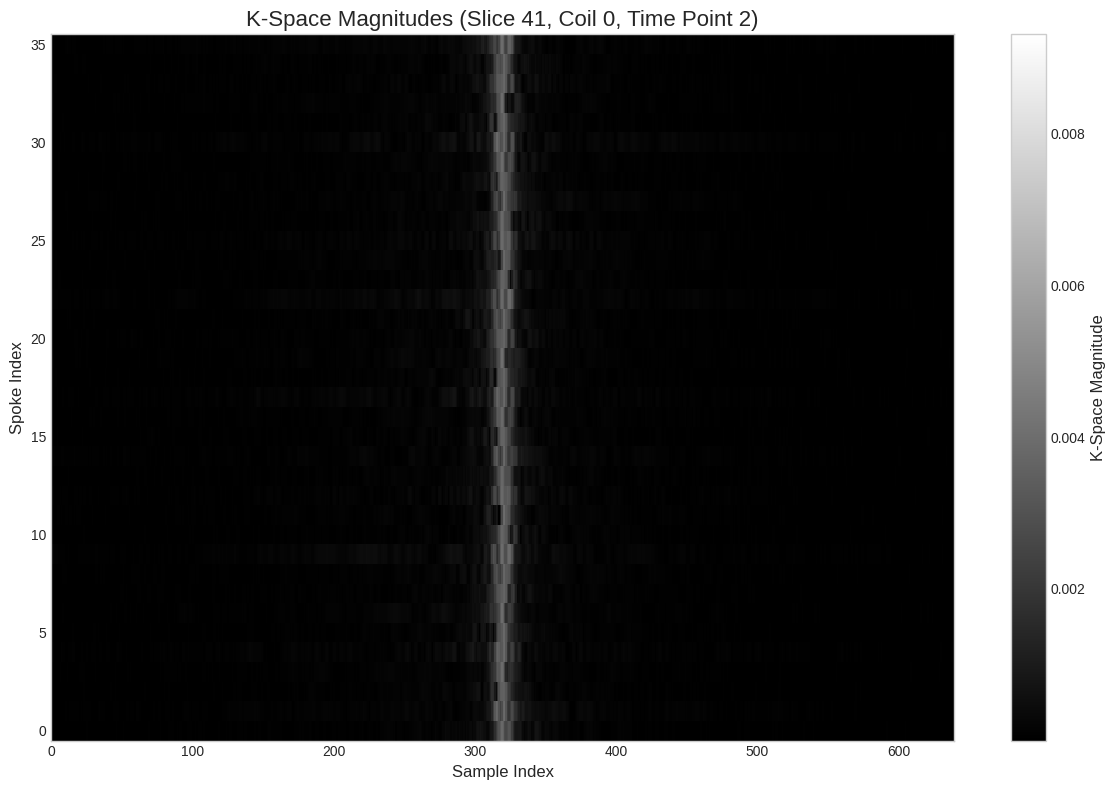

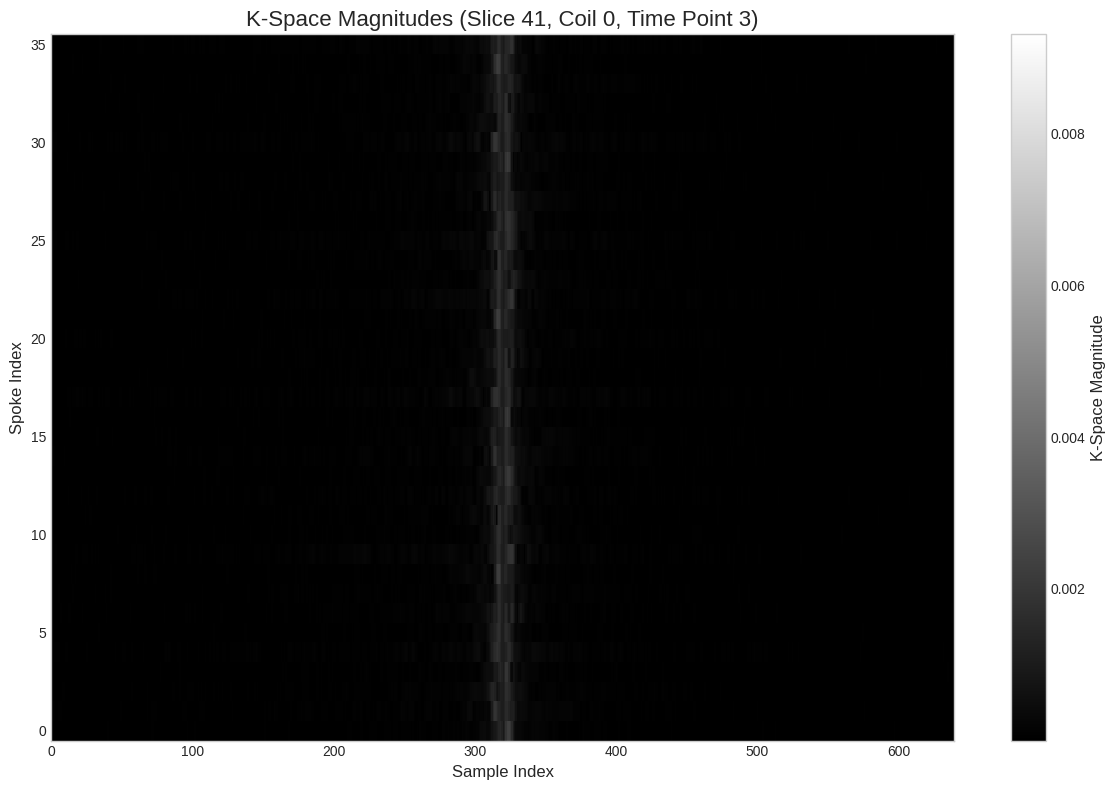

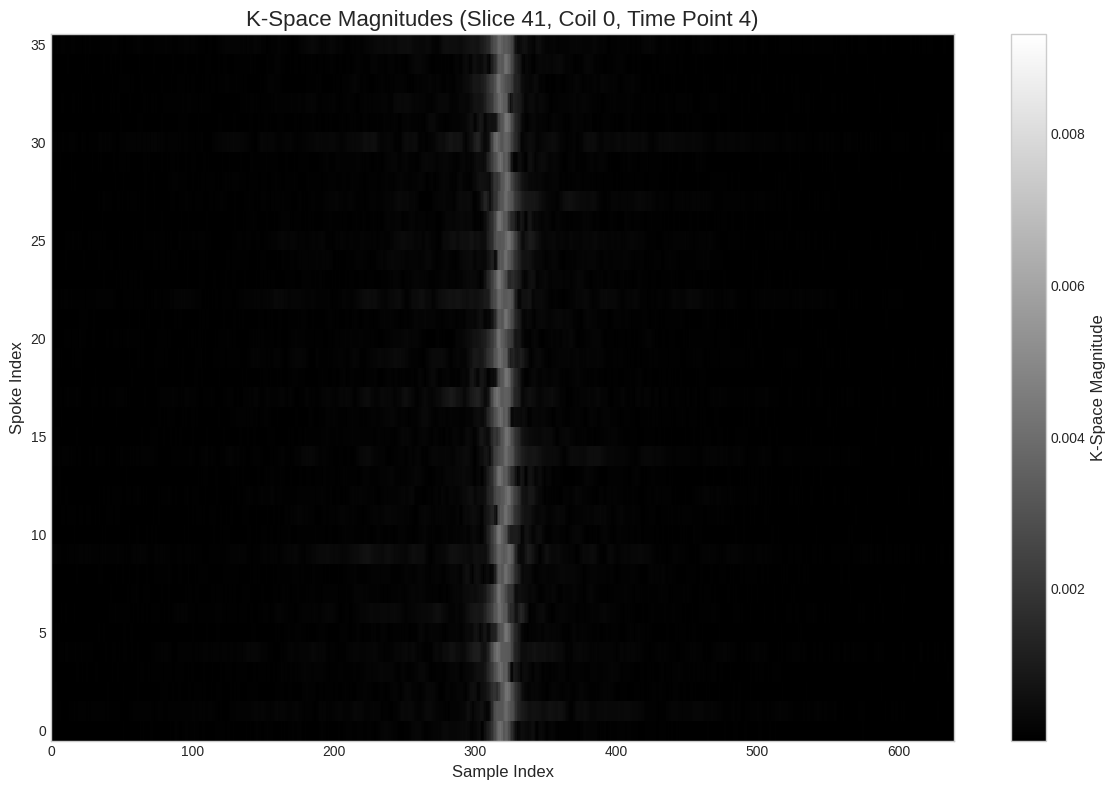

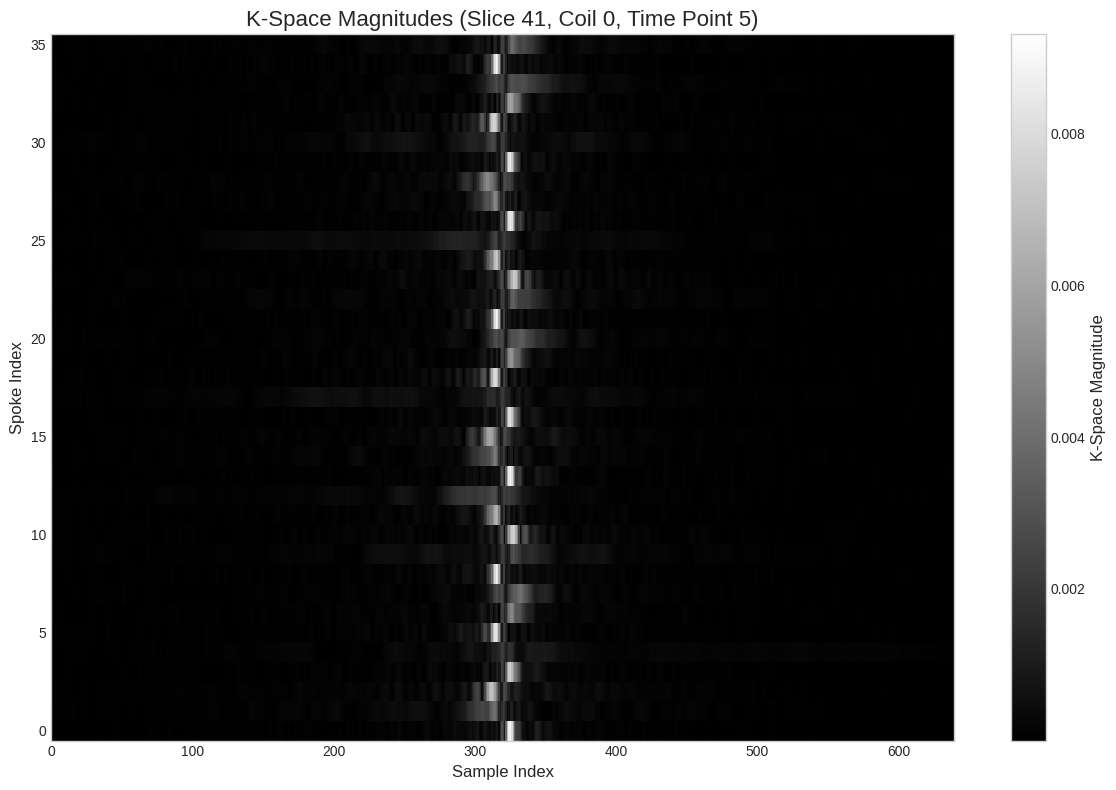

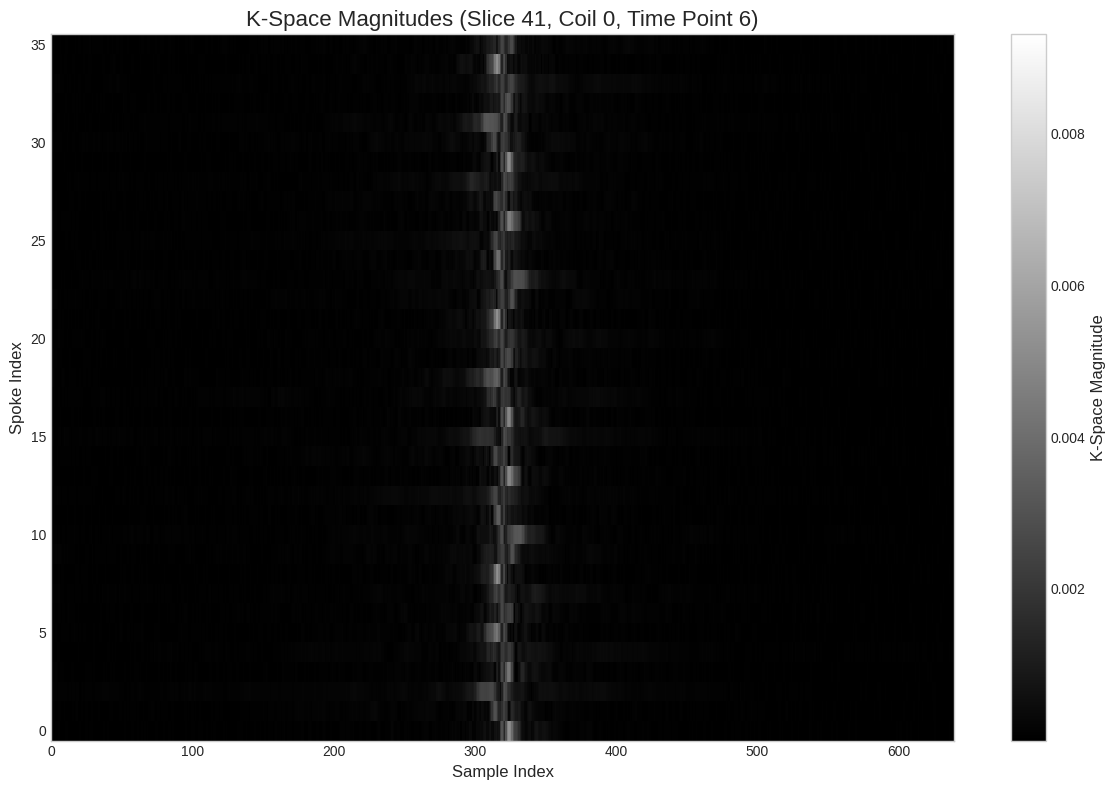

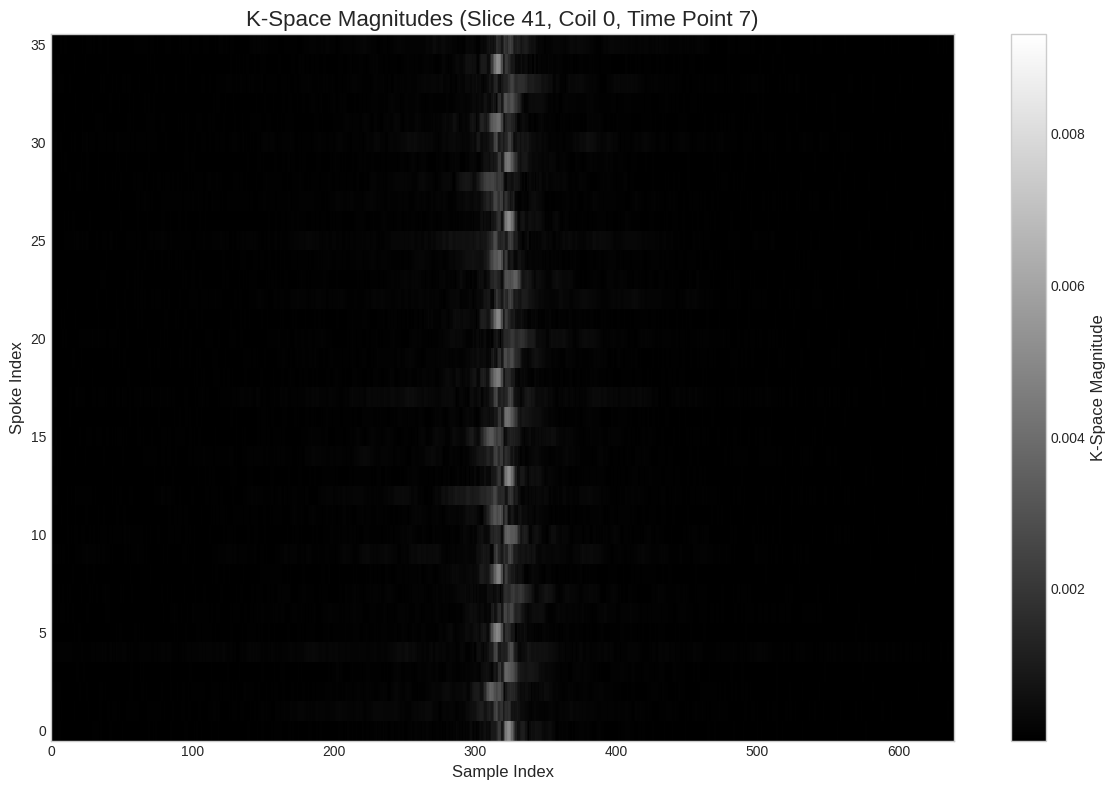

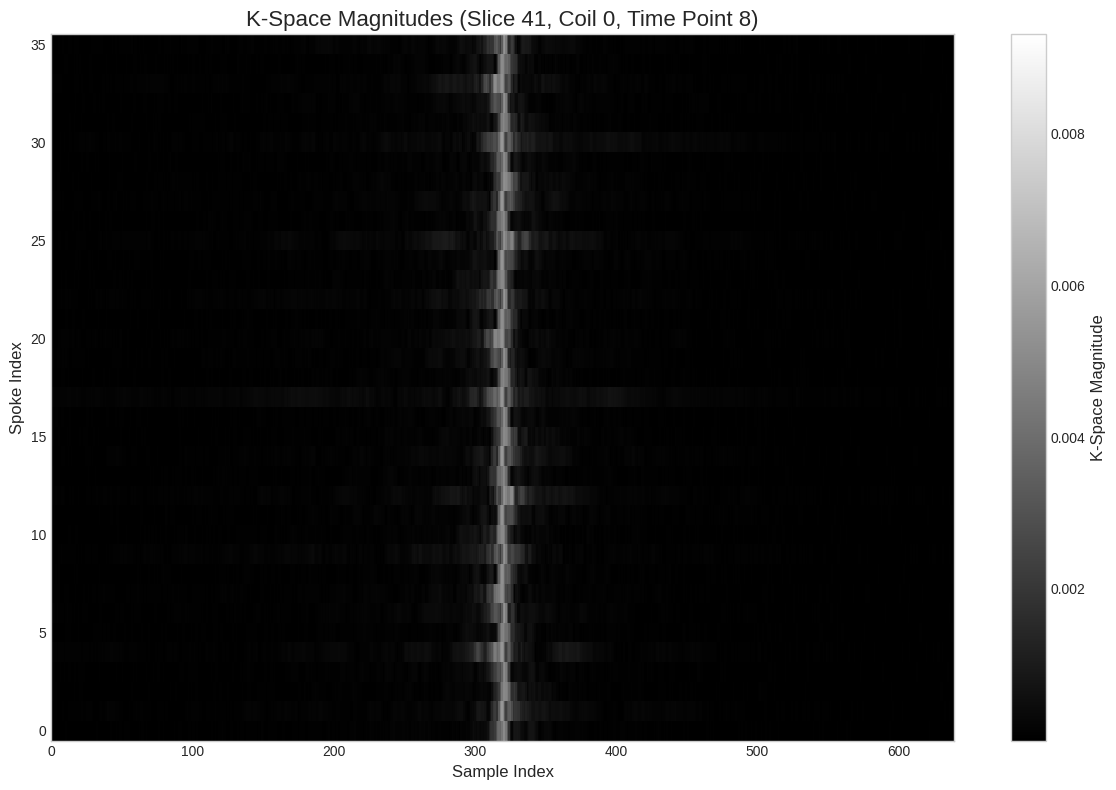

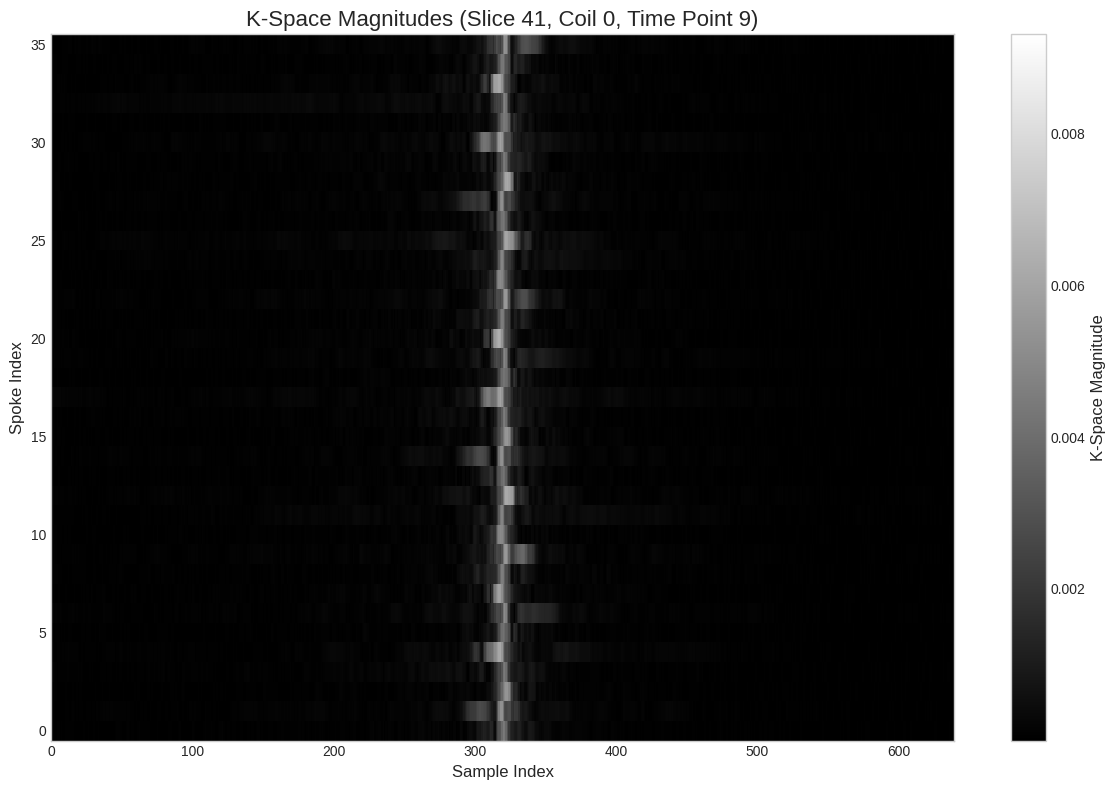

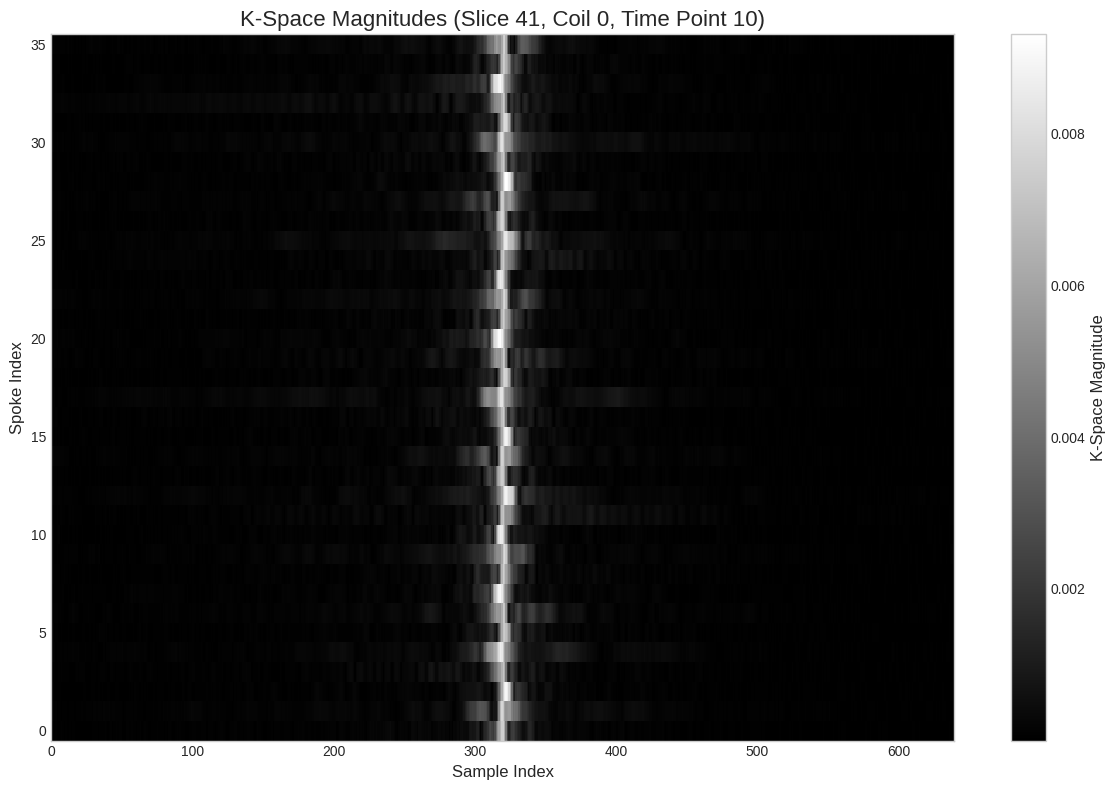

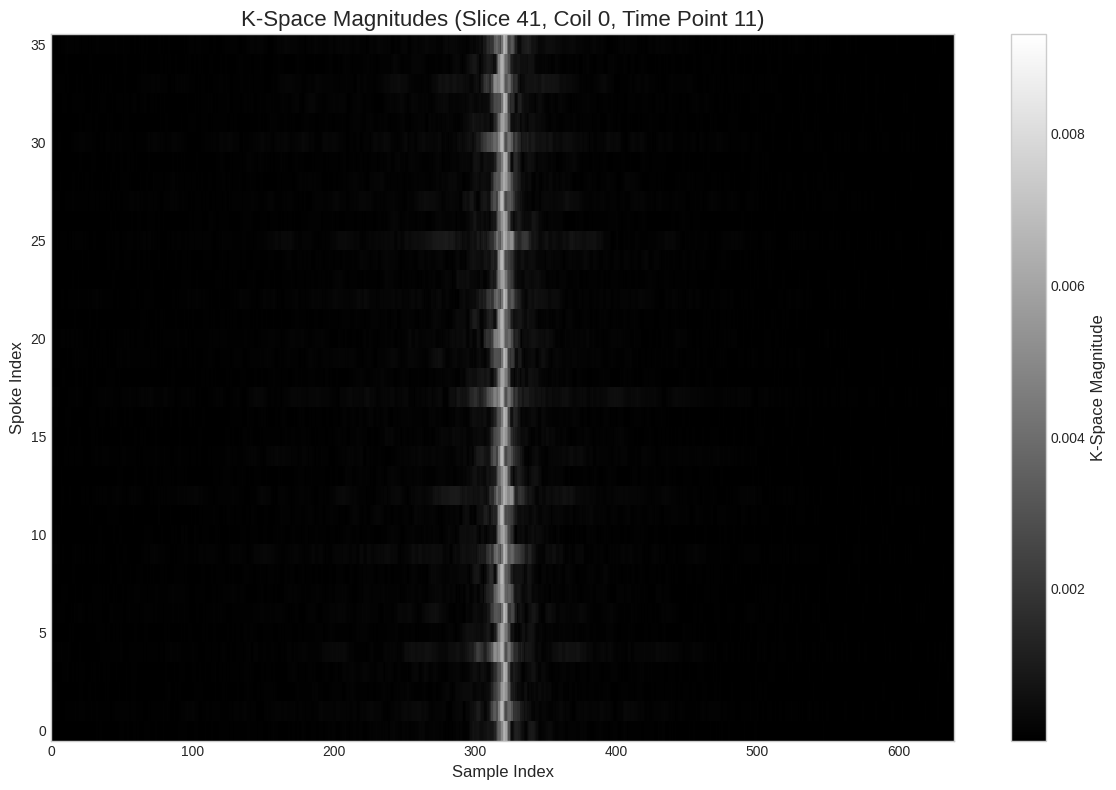

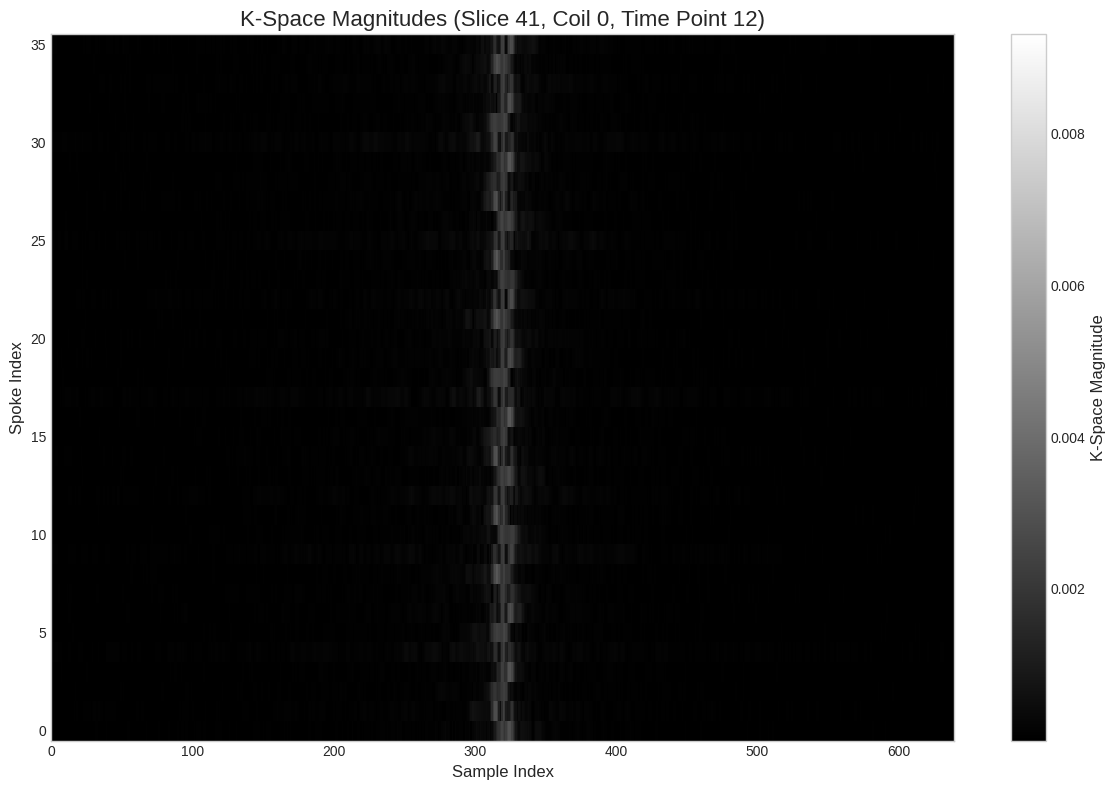

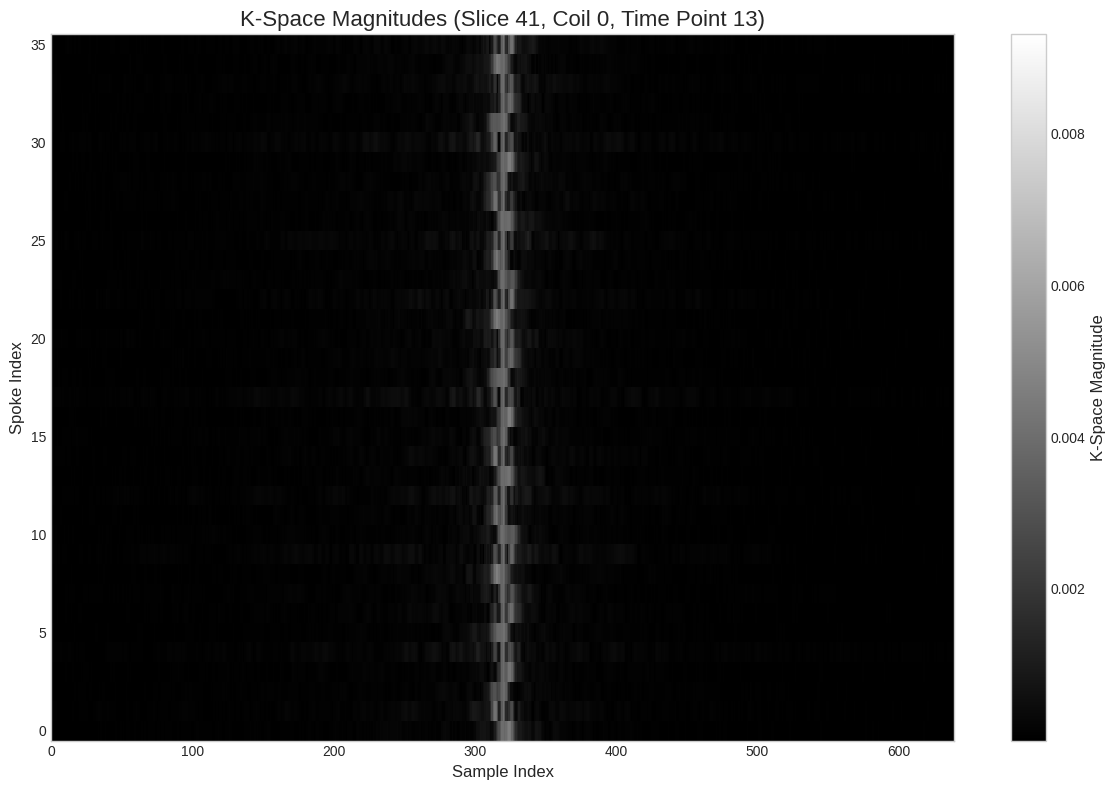

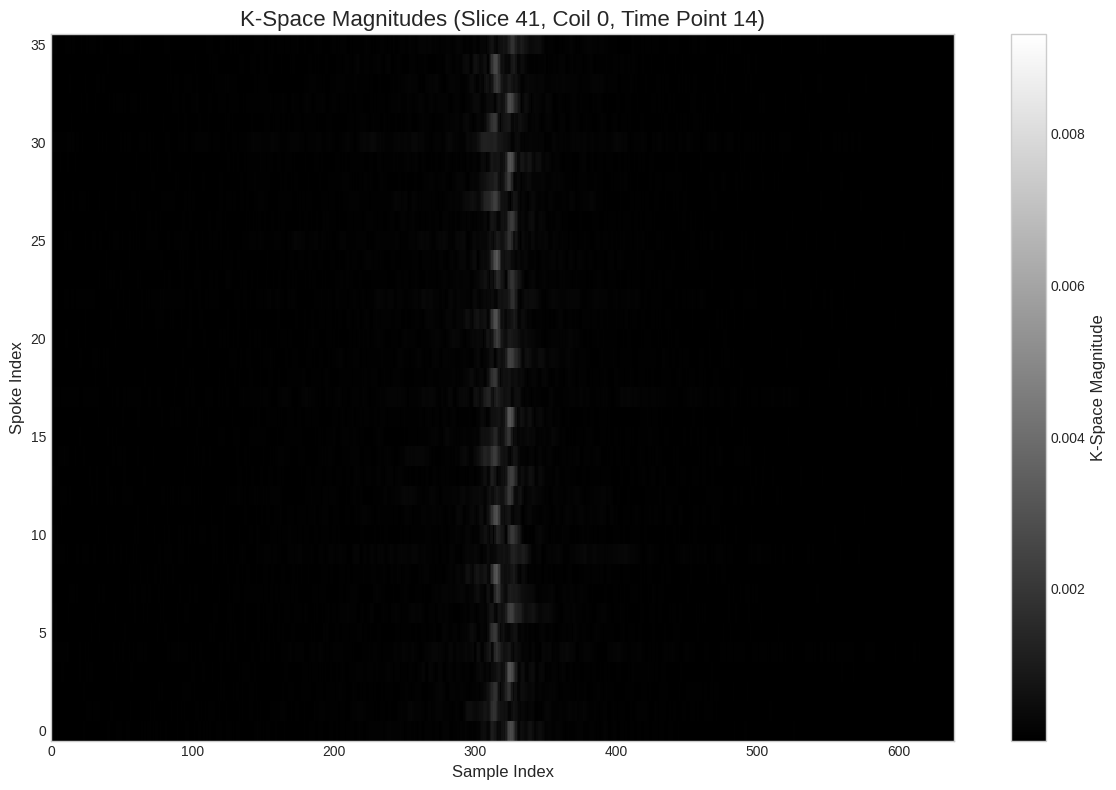

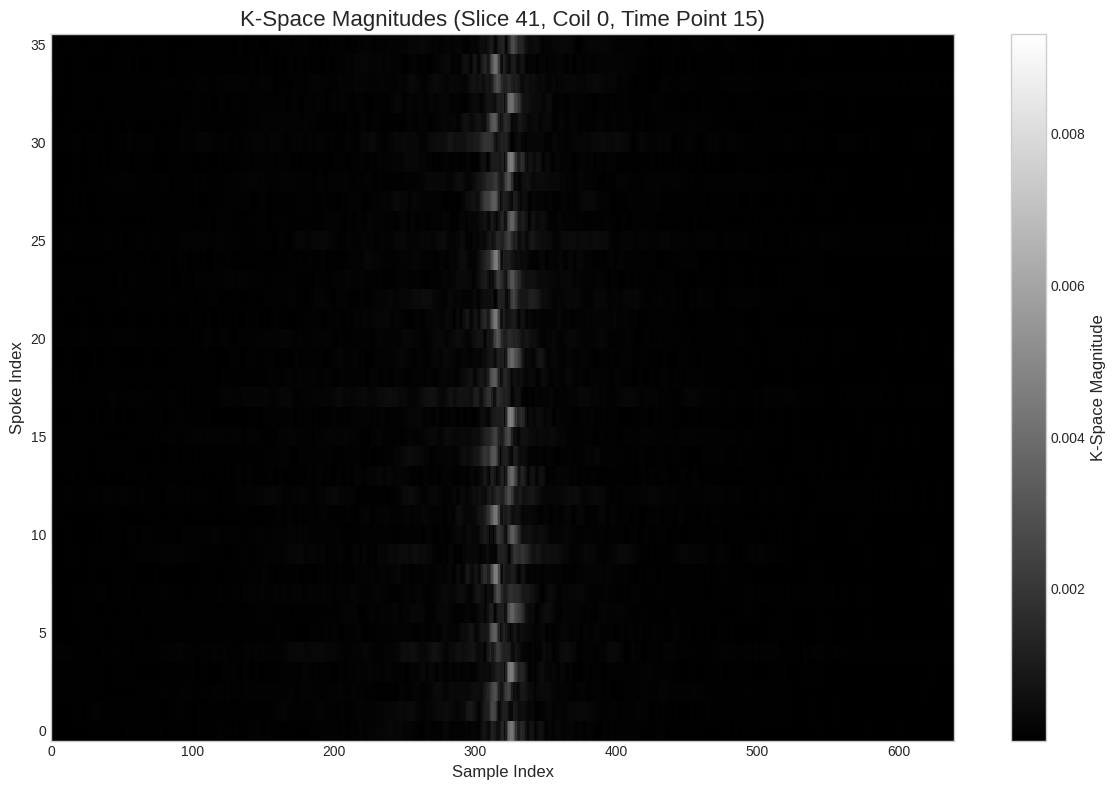

In [ ]:


kspace_path = '/ess/scratch/scratch1/rachelgordon/dce-8tf/binned_kspace/fastMRI_breast_001_2.h5'

with h5py.File(kspace_path, 'r') as f:
    kspace = torch.tensor(f['ktspace'][:])

    # Select a single slice and a single coil
    kspace_slice = kspace[41] # Your previously selected slice
    single_coil_kspace = kspace_slice[0] # Select the first coil (index 0)

    # Calculate the magnitude of the complex values for the selected coil.
    kspace_magnitudes = np.abs(single_coil_kspace.numpy())

    # Get dimensions: (time_points, spokes, samples)
    time_points, spokes_per_timepoint, samples = kspace_magnitudes.shape

    # Determine a global min/max for the color bar to keep it consistent across plots
    # This makes it easier to compare magnitudes across different time points.
    global_min_magnitude = kspace_magnitudes.min()
    global_max_magnitude = kspace_magnitudes.max()

    # Iterate through each time point
    for t_idx in range(time_points):
        # Extract data for the current time point
        current_time_point_magnitudes = kspace_magnitudes[t_idx, :, :] # Shape: (spokes_per_timepoint, samples)

        # Create meshgrid for plotting for this time point
        sample_indices = np.arange(samples)
        spoke_indices = np.arange(spokes_per_timepoint)

        # --- Plotting ---
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(12, 8))

        # Use pcolormesh for a 2D color plot
        # Use vmin and vmax to fix the color bar scale globally
        mesh = ax.pcolormesh(sample_indices, spoke_indices, current_time_point_magnitudes,
                             cmap='gray', shading='auto',
                             vmin=global_min_magnitude, vmax=global_max_magnitude)

        ax.set_title(f'K-Space Magnitudes (Slice 41, Coil 0, Time Point {t_idx})', fontsize=16)
        ax.set_xlabel('Sample Index', fontsize=12)
        ax.set_ylabel('Spoke Index', fontsize=12)
        
        # Add a color bar
        cbar = fig.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05)
        cbar.set_label('K-Space Magnitude', fontsize=12)

        plt.tight_layout()
        plt.show()